## This notebook preprocessed the raw dataset and trained machine learning models to classify news titles into 4 categories.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import re
import time
from tqdm import tqdm

from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score

import tensorflow_data_validation as tfdv

### Load data

In [2]:
path_data = '../data/NewsAggregatorDataset'
path_news = os.path.join(path_data, 'newsCorpora.csv')

cols = ['id', 'title', 'url', 'pulisher', 'category', 'story', 'hostname', 'timestep']
df_news = pd.read_csv(path_news, sep='\t', header=None, names=cols)
df_news.head()

,id,title,url,pulisher,category,story,hostname,timestep
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550
3,4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1394470372027


### Data Validation and Visualization

In [3]:
# Generate training dataset statistics
data_stats = tfdv.generate_statistics_from_dataframe(df_news)
# Visualize training dataset statistics
tfdv.visualize_statistics(data_stats)

### Data Preprocessing

In [4]:
def preprocess_text(text: str) -> str:
    """ Remove special characters, punctuations, etc.
    Args:
        text: input text
    
    Returns:
        text: preprocessed text (removed puncutations, numbers)
    """
    text = text.lower()
    remove_numbers = re.compile('[0-9]+')
    remove_special_characters = re.compile('[^A-Za-z0-9]+')
    
    text = re.sub(remove_numbers, ' ', text)
    text = re.sub(remove_special_characters, ' ', text)
    return text.strip()


def compute_tfidf(corpus: pd.Series, 
                  stop_words='english', 
                  ngram_range=(1, 1), 
                  max_features=None):
    """ Convert text to a matrix of TF-IDF features.
    Args:
        corpus: input content
        stop_words: Words in a stop list which are filtered out before or after processing of
        natural language data.
        ngram_range: The lower and upper boundary of the range of n-values for different
        n-grams to be extracted.
        max_features: If not None, build a vocabulary that only consider the top max_features
        ordered by term frequency across the corpus
        
    Returns:
        X: matrix of TF-IDF features
        vectorizer: TfidfVectorizer object
    """
    vectorizer = TfidfVectorizer(
        input='content', 
        stop_words=stop_words,
        ngram_range=ngram_range,
        min_df=3,
        max_df=0.9,
        max_features=max_features
    )
    vectorizer.fit(corpus)
    X = vectorizer.transform(corpus)
    print('done!')
    return X, vectorizer


def encode_labels(labels: list, data: pd.Series) -> pd.Series:
    """ Encode labels into numbers.
    Args:
        labels: labels for classes
        data: target data
    
    Returns
        result: encoded target data 
    """
    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(labels)
    result = label_encoder.transform(data)
    return result


def train_test_model(model, X_train, X_test, y_train, y_test,labels):
    """ Train and test the model using the training and test data sets. Return the predictions, accuracy and metric reports. """
    print('Start training...', end='')
    model.fit(X_train, y_train)
    print('done!')
    print('Start testing...', end='')
    predictions = model.predict(X_test)
    accuracy = model.score(X_test, y_test)
    metrics_report = classification_report(y_test, predictions, target_names=labels)
    precision, recall, fscore, train_support = score(y_test, predictions, average='weighted')
    print('done!')
    return predictions, accuracy, metrics_report, (precision, recall, fscore)

In [5]:
# remove unwanted columns and only leave title and category
df = df_news[['title', 'category']]
df.head()
# clean the title
df['title'] = df['title'].apply(preprocess_text)
# remove stop words
stop_words = 'english'
ngram_range = (1, 1)
max_features = None
X, vectorizer = compute_tfidf(df['title'], stop_words, ngram_range, max_features)
# encode labels
labels = df['category'].unique()
y = encode_labels(labels=labels, data=df['category'])

<ipython-input-5-ca4f0e9553b4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['title'] = df['title'].apply(preprocess_text)


done!


In [6]:
# split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
print('Training set Shape: {}  | Test set Shape: {}'.format(X_train.shape, X_test.shape))

Training set Shape: (337935, 27248)  | Test set Shape: (84484, 27248)


### Build and Train Models

### Logistic Regression

<class 'sklearn.linear_model._logistic.LogisticRegression'>
Number of documents = 337935  |  Number of features = 27248
Start training...done!
Start testing...done!
Total time: 68.05s
accuracy: 0.9449244827422943
              precision    recall  f1-score   support

           b       0.92      0.93      0.93     23193
           t       0.97      0.98      0.97     30494
           e       0.96      0.92      0.94      9128
           m       0.93      0.93      0.93     21669

    accuracy                           0.94     84484
   macro avg       0.94      0.94      0.94     84484
weighted avg       0.94      0.94      0.94     84484



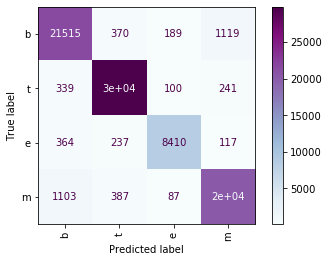

In [7]:
log_model = LogisticRegression(penalty='l2', max_iter=1000)
print(type(log_model))
print('Number of documents = {}  |  Number of features = {}'.format(X_train.shape[0], X_train.shape[1]))
st_time = time.time()
predictions, accuracy, metrics_report, log_prf = train_test_model(log_model, X_train, X_test, y_train, y_test, labels)
en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time))
print('accuracy: {}'.format(accuracy))
print('='*100)
print(metrics_report)
plot_confusion_matrix(log_model, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")

### Random Forest

Number of documents = 337935  |  Number of features = 27248
Start training...done!
Start testing...done!
Total time: 4.29s
accuracy: 0.4485819800198854
              precision    recall  f1-score   support

           b       0.95      0.17      0.29     23193
           t       0.40      1.00      0.57     30494
           e       1.00      0.00      0.00      9128
           m       0.98      0.16      0.27     21669

    accuracy                           0.45     84484
   macro avg       0.83      0.33      0.28     84484
weighted avg       0.76      0.45      0.35     84484



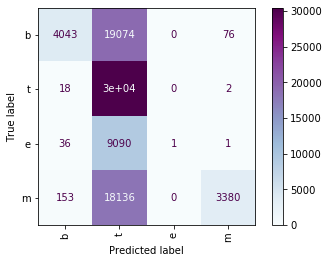

In [8]:
rf_model = RandomForestClassifier(n_estimators=50, max_depth=10, min_samples_split=10, n_jobs=-1, verbose=0)
print('Number of documents = {}  |  Number of features = {}'.format(X_train.shape[0], X_train.shape[1]))
st_time = time.time()
predictions, accuracy, metrics_report, rf_prf = train_test_model(rf_model, X_train, X_test, y_train, y_test, labels)
en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time))
print('accuracy: {}'.format(accuracy))
print('='*100)
print(metrics_report)
plot_confusion_matrix(rf_model, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")

### Gradient Boosting

Start training...done!
Start testing...done!
Total time: 898.50s
accuracy: 0.7921499928980635
              precision    recall  f1-score   support

           b       0.92      0.67      0.78     23193
           t       0.67      0.98      0.80     30494
           e       0.94      0.64      0.76      9128
           m       0.93      0.71      0.81     21669

    accuracy                           0.79     84484
   macro avg       0.86      0.75      0.79     84484
weighted avg       0.83      0.79      0.79     84484



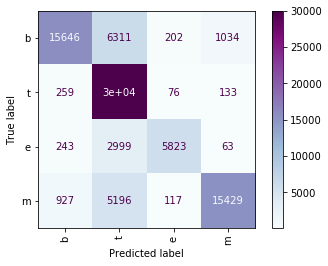

In [9]:
gb_model = GradientBoostingClassifier(n_estimators=50, max_depth=10)
st_time = time.time()
predictions, accuracy, metrics_report, gb_prf = train_test_model(gb_model, X_train, X_test, y_train, y_test, labels)
en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time))
print('accuracy: {}'.format(accuracy))
print(metrics_report)
plot_confusion_matrix(gb_model, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")

### Compare Performance

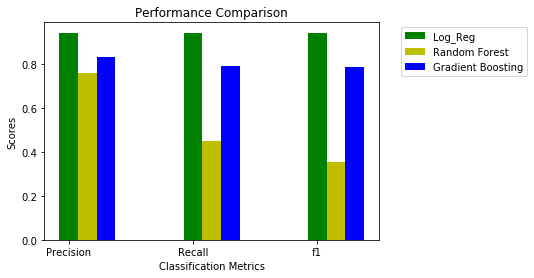

In [10]:
xx = np.array([1,2,3])
width = 0.15

ax = plt.subplot(111)
ax.bar(xx ,height=np.array(log_prf), width=width, color='g', align='center', label='Log_Reg', tick_label=['Precision', 'Recall', 'f1'])
ax.bar(xx + width, height=np.array(rf_prf), width=width, color='y', align='center', label='Random Forest')
ax.bar(xx + 2*width, height=np.array(gb_prf), width=width, color='b', align='center', label='Gradient Boosting')


plt.xlabel('Classification Metrics')
plt.ylabel('Scores')
plt.title("Performance Comparison")
plt.legend(bbox_to_anchor=(1.05, 1.0))
plt.show()

### Compare Training Time

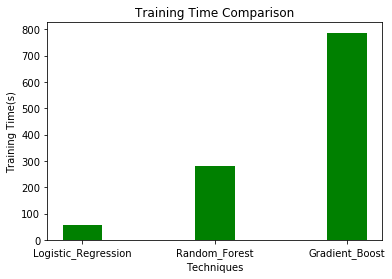

In [11]:
tr_times = [('Logistic_Regression', 58,70), ('Random_Forest', 280.10), ('Gradient_Boost', 786.70)]
x_vals = []
h_vals = []
for t in tr_times:
    x_vals.append(t[0])
    h_vals.append(t[1])
    
ax = plt.subplot(111)
ax.bar(np.linspace(0,1,3) - width, height=np.array(h_vals), width=width, color='Green', tick_label=x_vals)
plt.xlabel('Techniques')
plt.ylabel('Training Time(s)')
plt.title("Training Time Comparison")
plt.show()

### Cross Validation

In [12]:
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
log_model = LogisticRegression(penalty='l2', max_iter=1000)
accs = []
reports = []
st_time = time.time()
for train_index, test_index in skfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    predictions, accuracy, metrics_report, log_prf = train_test_model(log_model, X_train, X_test, y_train, y_test, labels)
    accs.append(accuracy)
    reports.append(metrics_report)

en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time))   
print('mean accuracy: {:.2f}'.format(np.mean(accs)))

Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Total time: 367.60s
mean accuracy: 0.95
